# Interpreting the Latent Dimensions

We're trying to make a pipeline that automates the process of interpreting the 20 latent dimensions captured using our previous frameworks. There are 2 approaches we will take:

1. For each of the 20 latent dimensions and each of the columns in our new dataset (representing some traits and characteristics), we compute the correlation matrix which will be in size of 20 x n (assuming n is the number of columns).
2. For each of the columns, we will do a linear regression, taking the latent dimensions as the predictors and the column values as the output. Then we compare the results by their $R^2$.

We are aware that the intersection between the 2 movie sets is not large. With that in mind, we will still proceed with the set of movies available. 

In [193]:
import pandas as pd
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

import json
import rapidfuzz

import pickle

import torch
from scipy.stats import spearmanr

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [13]:
file_path = "..//data//SWCPQ-Features-Survey-Dataset-November2023//data files//features-survey-dataset.csv"

data_0 =

/var/folders/4p/8nlm0n094791rk0xf6jzk8ch0000gn/T/ipykernel_70871/1690262793.py:3: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  data_0 = pd.read_csv(file_path, sep = "\t")


In [14]:
data_0.head()

,universe_assigned,universe_knowledge,universe_lastseen,universe_rating,universes_selected,universes_unselected,gender,age_group,engNat,country,...,jung_type,enn_type,quiz_items,char_ratings,year,introelapse,testelapse,endelapse,surveyelapse,screen
0,HP,3,3,-1,HP,"TO,GOT,TW,L,PP,F,DS9,ALA,WW",2,2,2,IN,...,NaN,NaN,"[[0, 28, 6, 19593], [1, 15, 66, 154985], [2, 2...","[[12, 5, 28, 21471], [15, 9, 60, 23446], [21, ...",2019,130,291,11,663,1
1,F,5,3,-1,F,"DS9,L,GOT,PP,TO,WW,HP,TW,ALA",2,3,1,US,...,NaN,NaN,"[[0, 7, 29, 57681], [1, 20, 86, 11739], [2, 15...","[[1, 5, 69, 11217], [4, 28, 13, 6767], [2, 27,...",2019,109,138,8,263,2
2,HP,5,2,-1,"TO,F,HP","L,TW,ALA,PP,GOT,WW,DS9",2,1,1,US,...,NaN,NaN,"[[0, 7, 7, 5887], [1, 8, 78, 3323], [2, 9, 40,...","[[23, 2, 96, 4969], [15, 14, 64, 4493], [27, 2...",2019,2,51,5,148,1
3,ALA,5,3,-1,"ALA,HP","F,TW,GOT,TO,WW,PP,DS9,L",2,2,1,GB,...,NaN,NaN,"[[0, 5, 55, 9836], [1, 20, 31, 3448], [2, 9, 6...","[[8, 2, 100, 3862], [10, 6, 74, 5533], [4, 11,...",2019,1081,60,5,151,1
4,ALA,3,3,-1,"ALA,HP","L,TW,PP,DS9,GOT,TO,F,WW",1,1,2,PH,...,NaN,NaN,"[[0, 28, 100, 8258], [1, 7, 2, 9135], [2, 19, ...","[[8, 19, 17, 7037], [5, 16, 63, 5858], [4, 1, ...",2019,23,60,4,175,2


## Data Checking and Pre-processing

In [7]:
file_path_1 = "..//data/SWCPQ-Features-Survey-Dataset-November2023//scripts//aggregated-means.csv"

data_1 = pd.read_csv(file_path_1, sep='\t')

file_path_2 = "..//data/SWCPQ-Features-Survey-Dataset-November2023//scripts//aggregated-n.csv"

data_2 = pd.read_csv(file_path_2, sep ='\t')

file_path_3 = "..//data/SWCPQ-Features-Survey-Dataset-November2023//scripts//aggregated-std.csv"

data_3 = pd.read_csv(file_path_3, sep = "\t")

In [8]:
data_1.head()

,Unnamed: 0,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F491,F492,F493,F494,F495,F496,F497,F498,F499,F500
0,MLP/1,40.4,88.0,16.9,38.2,37.5,73.6,74.9,54.5,82.3,...,84.5,53.6,37.3,21.0,67.2,62.1,30.4,45.7,19.8,50.9
1,MLP/2,70.1,56.0,31.6,80.5,59.9,76.3,15.0,35.7,20.2,...,70.7,34.7,51.5,26.6,75.2,46.2,63.6,86.1,51.6,16.0
2,MLP/3,63.0,82.1,32.7,96.9,12.8,87.5,42.5,33.6,8.6,...,60.0,40.9,62.5,35.1,59.1,37.6,60.3,97.1,49.9,23.7
3,MLP/4,3.6,92.4,5.2,87.9,34.7,70.7,72.9,89.5,60.0,...,77.2,83.2,1.9,10.2,38.4,7.4,76.9,49.8,80.4,61.9
4,MLP/5,26.9,63.9,29.9,35.9,56.1,63.5,56.7,61.5,62.2,...,50.3,66.6,26.5,53.9,70.6,51.1,68.2,40.7,52.1,42.7


In [9]:
data_2.head()

,Unnamed: 0,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F491,F492,F493,F494,F495,F496,F497,F498,F499,F500
0,MLP/1,75,59,68,91,68,72,76,83,67,...,25,26,30,32,31,24,27,26,29,30
1,MLP/2,80,82,61,84,74,66,67,83,72,...,25,27,24,24,28,25,28,32,26,25
2,MLP/3,84,82,67,94,73,80,77,85,65,...,33,33,27,27,28,25,24,37,29,26
3,MLP/4,82,65,70,75,79,55,58,101,62,...,26,26,29,24,26,25,25,25,23,25
4,MLP/5,61,68,73,78,67,55,63,76,66,...,30,22,32,27,24,27,29,22,25,29


(array([2.2288e+04, 6.7783e+04, 7.2844e+04, 6.6782e+04, 6.4297e+04,
        6.0991e+04, 5.6821e+04, 5.0194e+04, 4.3424e+04, 3.7045e+04,
        3.1825e+04, 2.7302e+04, 2.3601e+04, 2.0022e+04, 1.7685e+04,
        1.0839e+04, 1.5234e+04, 1.3716e+04, 1.2467e+04, 1.1928e+04,
        1.0984e+04, 1.0217e+04, 9.2240e+03, 8.5270e+03, 7.8940e+03,
        7.3440e+03, 6.6890e+03, 6.2180e+03, 5.6160e+03, 5.4540e+03,
        5.1120e+03, 3.2550e+03, 4.7700e+03, 4.4260e+03, 4.3360e+03,
        4.2350e+03, 4.2200e+03, 4.0300e+03, 3.7350e+03, 3.6250e+03,
        3.5170e+03, 3.3340e+03, 3.2080e+03, 3.0220e+03, 2.8980e+03,
        2.7300e+03, 1.6780e+03, 2.4540e+03, 2.2630e+03, 2.2140e+03,
        2.0430e+03, 2.0090e+03, 1.9220e+03, 1.8150e+03, 1.8120e+03,
        1.6940e+03, 1.6760e+03, 1.5770e+03, 1.6020e+03, 1.6540e+03,
        1.5250e+03, 1.4700e+03, 1.0500e+03, 1.4550e+03, 1.5490e+03,
        1.4920e+03, 1.4030e+03, 1.3660e+03, 1.3780e+03, 1.3510e+03,
        1.3910e+03, 1.3460e+03, 1.2830e+03, 1.30

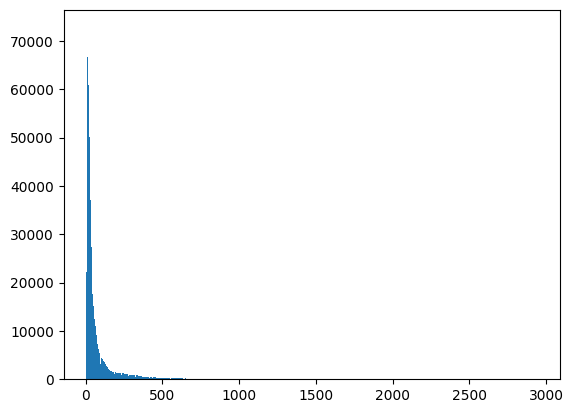

In [22]:
k = []
for row in data_2:
    for col in data_2[row]:
        if type(col) == str:
            continue
        k.append(int(col))

plt.hist(k, bins=1000)

(array([ 8397., 33858., 47816., 49363., 46225., 44038., 43234., 41746.,
        40308., 38350., 36112., 32553., 29623., 26718., 24128., 21675.,
        19689., 17763., 16177.,  7424., 13697., 12587., 11423., 10839.,
        10303.,  9734.,  8913.,  8383.,  8114.,  7898.,  7584.,  6840.,
         6777.,  6306.,  5797.,  5648.,  5373.,  5111.,  4754.,  2365.,
         4324.,  4255.,  3830.,  3749.,  3729.,  3451.,  3386.,  3255.,
         3125.,  3120.,  2951.,  2929.,  2822.,  2820.,  2876.,  2732.,
         2642.,  2544.,  2440.,  1215.,  2343.,  2335.,  2246.,  2167.,
         2129.,  2034.,  1975.,  1911.,  1850.,  1742.,  1634.,  1636.,
         1532.,  1489.,  1456.,  1368.,  1353.,  1331.,  1290.,   632.,
         1184.,  1253.,  1190.,  1159.,  1102.,  1109.,  1027.,  1087.,
         1065.,  1085.,  1090.,  1004.,   979.,  1022.,  1027.,   947.,
         1053.,  1003.,   985.,   919.]),
 array([  4.  ,   5.95,   7.9 ,   9.85,  11.8 ,  13.75,  15.7 ,  17.65,
         19.6 ,  21.55

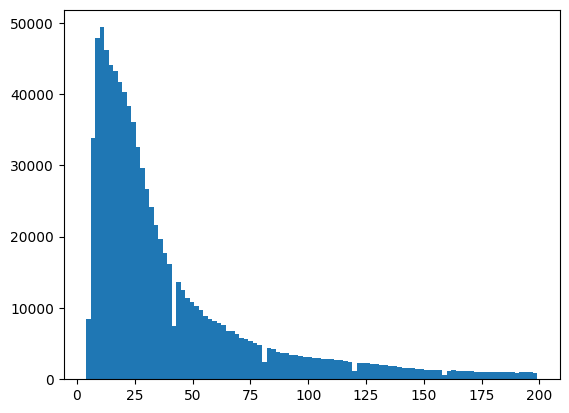

In [23]:
plt.hist([i for i in k if i < 200], bins=100)

In [10]:
data_3.head()

,Unnamed: 0,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F491,F492,F493,F494,F495,F496,F497,F498,F499,F500
0,MLP/1,29.7,15.6,15.8,23.6,27.8,24.7,24.1,28.7,20.3,...,18.9,35.0,28.4,18.0,25.9,25.3,25.3,24.7,14.7,29.0
1,MLP/2,26.3,28.5,26.1,19.4,29.4,22.8,22.3,28.6,19.3,...,29.0,25.7,24.0,26.4,17.4,28.6,26.2,15.8,24.6,17.8
2,MLP/3,25.4,22.4,21.4,8.1,20.3,16.4,32.0,24.5,10.5,...,29.9,29.2,22.6,25.3,31.4,24.1,32.3,5.9,28.4,28.5
3,MLP/4,6.0,15.8,10.5,17.5,32.9,26.1,28.6,14.1,27.7,...,28.5,23.1,3.5,15.2,28.7,8.6,22.5,25.8,20.6,33.6
4,MLP/5,24.7,27.9,25.1,24.2,26.9,27.7,28.6,30.4,23.9,...,29.6,33.5,24.7,28.0,22.7,27.7,22.7,24.1,24.1,34.2


Check for missing values

In [59]:
print(sum(data_1.isna().sum()))
print(sum(data_2.isna().sum()))
print(sum(data_3.isna().sum()))

0
0
0


The first column (storing the character code) currently has a not meaningful column name. Let's change its name into "character_code".

In [74]:
data_1.rename(columns={'Unnamed: 0': 'character_code'}, inplace=True)
data_2.rename(columns={'Unnamed: 0': 'character_code'}, inplace=True)
data_3.rename(columns={'Unnamed: 0': 'character_code'}, inplace=True)

### Intersection of the movie set in movies.csv and character rating survey

Since the same movies might have different title formats across 2 sets, we use simmilarity function to confirm this. 

In [101]:
with open("..//data//moral_data_full.json", "r") as f:
    movie_data = json.load(f)

We need to make sure we only contain the characters that satisfy all the conditions

In [112]:
movie_character_dict_100 = {}

for movie, characters in movie_data["moral_dialogue"].items():
    filtered_characters = {
        character: True  # or you can store len(sentences) if you want
        for character, sentences in characters.items()
        if len(sentences) >= 100
    }

    if filtered_characters:
        movie_character_dict_100[movie] = filtered_characters

In [60]:
with open("..//data/SWCPQ-Features-Survey-Dataset-November2023//scripts//subjects.json", "r") as f:
    subjects = json.load(f)

movies_in_subjects = []
for subject in subjects:
    movies_in_subjects.append((subject, subjects[subject]["name"]))

In [103]:
len(movie_character_dict_100.keys())

264

In [61]:
from rapidfuzz import process, fuzz
import re

def normalize(title):
    title = title.lower()
    title = re.sub(r'[^\w\s]', '', title)  # remove punctuation
    title = re.sub(r'\b(the|a|an)\b', '', title)  # optional: remove stop words
    title = re.sub(r'\s+', ' ', title).strip()  # remove extra whitespace
    return title

def get_similar_titles(set1, set2, threshold=85, set2_tuples = False):
    matched = []
    if set2_tuples:
        set2_normalized = [normalize(t[1]) for t in set2]
    else:
        set2_normalized = [normalize(t) for t in set2]

    for title1 in set1:
        title1_norm = normalize(title1)
        best_match = process.extractOne(title1_norm, set2_normalized, scorer=fuzz.token_sort_ratio)  # TO DO: check if this is the best appraoch
        if best_match and best_match[1] >= threshold:
            matched.append((title1, set2[set2_normalized.index(best_match[0])]))
    
    return matched

In [104]:
set1 = list(movie_data["moral_dialogue"].keys())
set2 = movies_in_subjects

pairs = get_similar_titles(set1, set2, threshold=85, set2_tuples=True)

In [105]:
for k in pairs:
    print(k)

('500 Days of Summer', ('DS', '(500) Days of Summer'))
('Annie Hall', ('AH', 'Annie Hall'))
('Big Sick, The', ('TBS', 'The Big Sick'))
('Catch Me If You Can', ('CMYC', 'Catch Me If You Can'))
('Departed, The', ('TDPT', 'The Departed'))
('Devil Wears Prada, The', ('DWP', 'The Devil Wears Prada'))
('Fault in Our Stars, The', ('FOS', 'The Fault in Our Stars'))
("Ferris Bueller's Day Off", ('FBDO', 'Ferris Bueller&apos;s Day Off'))
('Fight Club', ('FC', 'Fight Club'))
('Forrest Gump', ('FG', 'Forrest Gump'))
('Groundhog Day', ('GHD', 'Groundhog Day'))
('Hangover, The', ('HO', 'The Hangover'))
('Inception', ('I', 'Inception'))
('Jane Eyre', ('JE', 'Jane Eyre'))
("One Flew Over the Cuckoo's Nest", ('OFOCN', "One Flew Over the Cuckoo's Nest"))
('Pride and Prejudice', ('PP', 'Pride and Prejudice'))
('Se7en', ('S7', 'Se7en'))
('Sex and the City', ('SC', 'Sex and the City'))
('Shawshank Redemption, The', ('SR', 'The Shawshank Redemption'))
('Silver Linings Playbook', ('SLP', 'Silver Linings Play

In [106]:
len(pairs)  #  92

21

Some characters really have too few moral sentences among the 100+ moral sentences they have. Therefore, we put a threshold=20 to the number of moral sentences per character. We put away the characters below these thresholds. These characters are stored in exception_data dictionary.

In [52]:
exception_data = {
    "Ace Ventura: Pet Detective": ["ACE"],
    "Amadeus": ["MOZART"],
    "Big Eyes": ["WALTER"],
    "Boyhood": ["DAD"],
    "Crazylove": ["LETTY"],
    "Deception": ["JONATHAN"],
    "Departed, The": ["COLIN"],
    "Fabulous Baker Boys, The": ["FRANK"],
    "Jay and Silent Bob Strike Back": ["JAY"],
    "Man Trouble": ["HARRY"],
    "Manhattan Murder Mystery": ["CAROL"],
    "Midnight in Paris": ["GIL"],
    "Never Been Kissed": ["JOSIE"],
    "Notting Hill": ["WILLIAM"],
    "One Flew Over the Cuckoo's Nest": ["MCMURPHY"],
    "Pineapple Express": ["SAUL"],
    "Pretty Woman (final script)": ["EDWARD"],
    "Saving Mr. Banks": ["PAMELA"],
    "Secret Life of Walter Mitty, The": ["WALTER"],
    "Semi-Pro": ["JACKIE MOON"],
    "Sherlock Holmes": ["HOLMES"],
    "Sideways": ["MILES"],
    "Sunset Blvd.": ["GILLIS"],
    "Superbad": ["SETH"],
    "Twins": ["VINCE"],
    "Two For The Money": ["WALTER"],
    "Ugly Truth, The": ["ABBY", "MIKE"]
}

In [114]:
new_pairs = []

for pair in pairs:
    if pair[0] in exception_data:
        continue
    if pair[0] not in movie_character_dict_100:
        continue
    new_pairs.append(pair)

pairs = new_pairs 

In [115]:
len(new_pairs)  # 18

18

In [133]:
new_pairs

[('500 Days of Summer', ('DS', '(500) Days of Summer')),
 ('Annie Hall', ('AH', 'Annie Hall')),
 ('Big Sick, The', ('TBS', 'The Big Sick')),
 ('Catch Me If You Can', ('CMYC', 'Catch Me If You Can')),
 ('Devil Wears Prada, The', ('DWP', 'The Devil Wears Prada')),
 ('Fault in Our Stars, The', ('FOS', 'The Fault in Our Stars')),
 ("Ferris Bueller's Day Off", ('FBDO', 'Ferris Bueller&apos;s Day Off')),
 ('Fight Club', ('FC', 'Fight Club')),
 ('Forrest Gump', ('FG', 'Forrest Gump')),
 ('Groundhog Day', ('GHD', 'Groundhog Day')),
 ('Hangover, The', ('HO', 'The Hangover')),
 ('Inception', ('I', 'Inception')),
 ('Jane Eyre', ('JE', 'Jane Eyre')),
 ('Pride and Prejudice', ('PP', 'Pride and Prejudice')),
 ('Se7en', ('S7', 'Se7en')),
 ('Sex and the City', ('SC', 'Sex and the City')),
 ('Shawshank Redemption, The', ('SR', 'The Shawshank Redemption')),
 ('Silver Linings Playbook', ('SLP', 'Silver Linings Playbook'))]

There are only 18 movies that sat

In [76]:
print(data_1.iloc[0])

character_code    MLP/1
F1                 40.4
F2                 88.0
F3                 16.9
F4                 38.2
                  ...  
F496               62.1
F497               30.4
F498               45.7
F499               19.8
F500               50.9
Name: 0, Length: 501, dtype: object


Load the 20 dimensional embeddings we got from our code in colab

In [81]:
with open("..//data/20d-embeddings/20_embeddings_full_default.pkl", "rb") as f:
    latent_full = pickle.load(f)

with open("..//data/20d-embeddings/20_embeddings_moral_only_default.pkl", "rb") as f:
    latent_moral_only = pickle.load(f)

In [97]:
list(latent_full.keys())

['1492: Conquest of Paradise_COLUMBUS',
 '30 Minutes or Less_WILL',
 '50-50_ADAM',
 '500 Days of Summer_TOM',
 '8MM_WELLES',
 'A Few Good Men_KAFFEE',
 'A Most Violent Year_ABEL',
 'A Serious Man_LARRY',
 'Ace Ventura: Pet Detective_ACE',
 'Adaptation_KAUFMAN',
 'Adjustment Bureau, The_DAVID',
 'Agnes of God_MARTHA',
 'All About Eve_MARGO',
 'All About Steve_MARY',
 "All the King's Men_WILLIE",
 'Amelia_AMELIA',
 'American Hustle_IRVING ROSENFELD',
 'American President, The_SHEPHERD',
 'American Psycho_BATEMAN',
 'Analyze That_BEN',
 'Analyze This_VITTI',
 'Analyze This_BEN',
 'Angel Eyes_SHARON',
 'Annie Hall_ALVY',
 'Apartment, The_BUD',
 'Apt Pupil_DUSSANDER',
 'Apt Pupil_TODD',
 'Arsenic and Old Lace_MORTIMER',
 'Arthur_ARTHUR',
 'August: Osage County_BARBARA',
 'Back-up Plan, The_ZOE',
 'Bad Teacher_ELIZABETH',
 'Bamboozled_DELACROIX',
 'Barry Lyndon_RODERICK',
 'Basic_HARDY',
 'Being Human_HECTOR',
 'Believer, The_DANNY',
 'Big Eyes_WALTER',
 'Big Fish_EDWARD',
 'Big Lebowski, Th

In [166]:
latent_moral_only.keys()

dict_keys(['1492: Conquest of Paradise_COLUMBUS', '30 Minutes or Less_WILL', '50-50_ADAM', '500 Days of Summer_TOM', '8MM_WELLES', 'A Few Good Men_KAFFEE', 'A Most Violent Year_ABEL', 'A Serious Man_LARRY', 'Adaptation_KAUFMAN', 'Adjustment Bureau, The_DAVID', 'Agnes of God_MARTHA', 'All About Eve_MARGO', 'All About Steve_MARY', "All the King's Men_WILLIE", 'Amelia_AMELIA', 'American Hustle_IRVING ROSENFELD', 'American President, The_SHEPHERD', 'American Psycho_BATEMAN', 'Analyze That_BEN', 'Analyze This_VITTI', 'Analyze This_BEN', 'Angel Eyes_SHARON', 'Annie Hall_ALVY', 'Apartment, The_BUD', 'Apt Pupil_DUSSANDER', 'Apt Pupil_TODD', 'Arsenic and Old Lace_MORTIMER', 'Arthur_ARTHUR', 'August: Osage County_BARBARA', 'Back-up Plan, The_ZOE', 'Bad Teacher_ELIZABETH', 'Bamboozled_DELACROIX', 'Barry Lyndon_RODERICK', 'Basic_HARDY', 'Being Human_HECTOR', 'Believer, The_DANNY', 'Big Fish_EDWARD', 'Big Lebowski, The_DUDE', 'Big Lebowski, The_WALTER', 'Big Sick, The_KUMAIL', 'Blind Side, The_LEIG

After we get all the matching movie pairs from the 2 sets, we match the characters from each pair and store the ratings. Make sure the keys are in the same format as the original movie dialogue data. Later we will load the 20-dimensional embeddings data from colab and do both methodologies we described at the beginning. 

In [168]:
structured_data = {}
similarity_threshold = 85

for pair in pairs:
    dct = {}
    dct["subject_name"] = pair[1][1]  # The corresponding title in the subject.json of the movie
    dct["subject_code"] = pair[1][0]  # The corresponding code in the subject.json of the movie
    dct["characters"] = {}
    
    for char_index in subjects[pair[1][0]]:
        if char_index == "name" or char_index == "N":  # skip the name and n keys since they are not characters
            continue

        # Find the corresponding character name in moral_character_dict_100
        # We can use string similarity or find fraction of the character name
        character_subject_name = subjects[pair[1][0]][char_index]
        if isinstance(character_subject_name, list):  # Ensure it's a list before accessing the first element
            character_subject_name = character_subject_name[0]
        else:
            continue
        
        # Use substring matching to find the best match for the character name
        best_match = None
        for char_name in movie_character_dict_100[pair[0]].keys():
            if char_name.lower() in character_subject_name.lower():
                best_match = (char_name, similarity_threshold, 0)  # Mock similarity score to pass the threshold
                break

        print("i got here", character_subject_name, best_match)

        if best_match and best_match[1] >= similarity_threshold: 
            char_name = best_match[0]
        else:
            continue

        # If the character name is in the exception data, we skip it
        if pair[0] in exception_data and char_name in exception_data[pair[0]]:
            continue

        # Once we find the character, we store the character code, name in dialogue data, name in subjects, rating, and the latent embeddings
        char_dct = {}

        char_dct["character_name"] = char_name

        # Use the corresponding character name to find the embedding
        char_dialogue_name = None

        char_dct["subject_name"] = character_subject_name

        char_dct["subject_code"] = pair[1][0] + "/" + str(char_index)

        rating_data = data_1[data_1["character_code"] == char_dct["subject_code"]]
        rating_data = rating_data.iloc[0].tolist()
        
        char_dct["rating"] = rating_data[1:]  # Skip the character_code column

        # Get the latent embeddings for the character
        name_in_latent = pair[0] + "_" + char_name

        if name_in_latent in latent_full:
            char_dct["latent_full"] = latent_full[name_in_latent]

        if name_in_latent in latent_moral_only:
            char_dct["latent_moral_only"] = latent_moral_only[name_in_latent]
        else:
            char_dct["latent_moral_only"] = None

        # Store the data in dct["characters"][]
        dct["characters"][char_name] = char_dct
        

    structured_data[pair[0]] = dct

i got here Tom Hansen ('TOM', 85, 0)
i got here Summer Finn None
i got here Alvy Singer ('ALVY', 85, 0)
i got here Annie Hall None
i got here Kumail Nanjiani ('KUMAIL', 85, 0)
i got here Emily Gardner None
i got here Frank Abagnale ('FRANK', 85, 0)
i got here Carl Hanratty None
i got here Miranda Priestly None
i got here Andrea Sachs None
i got here Emily Charlton None
i got here Hazel Grace Lancaster ('HAZEL', 85, 0)
i got here Augustus 'Gus' Waters ('GUS', 85, 0)
i got here Ferris Bueller ('FERRIS', 85, 0)
i got here Cameron Frye None
i got here Sloane Peterson None
i got here Tyler Durden ('TYLER', 85, 0)
i got here The Narrator None
i got here Marla Singer None
i got here Forrest Gump ('FORREST', 85, 0)
i got here Jenny Curran None
i got here Dan Taylor None
i got here Phil Connors ('PHIL', 85, 0)
i got here Rita Hanson None
i got here Phil None
i got here Stu None
i got here Alan None
i got here Dom Cobb ('COBB', 85, 0)
i got here Arthur None
i got here Ariadne None
i got here Mal

In [172]:
for movie in structured_data:
    if not structured_data[movie]["characters"]:
        print(f"No characters found for {movie}. Skipping.")

We need to insert these characters manually

In [171]:
# The Hangover - VICK
dct = {}
dct["subject_name"] = "Phil"
dct["subject_code"] = "HO/1"
dct["character_name"] = "VICK"
dct["rating"] = data_1[data_1["character_code"] == "HO/1"].iloc[0].tolist()[1:]  # Skip the character_code column
name_in_latent = "Hangover, The" + "_" + "VICK"

dct["latent_full"] = latent_full.get(name_in_latent, None)
dct["latent_moral_only"] = latent_moral_only.get(name_in_latent, None)

structured_data["Hangover, The"]["characters"]["VICK"] = dct

# The Devil Wears Prada - ANDY
dct = {}
dct["subject_name"] = "Andrea Sachs"
dct["subject_code"] = "DWP/2"
dct["character_name"] = "ANDY"
dct["rating"] = data_1[data_1["character_code"] == "DWP/2"].iloc[0].tolist()[1:]  # Skip the character_code column
name_in_latent = "Devil Wears Prada, The" + "_" + "ANDY"

dct["latent_full"] = latent_full.get(name_in_latent, None)
dct["latent_moral_only"] = latent_moral_only.get(name_in_latent, None)
structured_data["Devil Wears Prada, The"]["characters"]["ANDY"] = dct

Before proceeding, let's get the mean and standard deviation of the latent sentence embeddings of each character. This is important as we can not do the correlation for all the sentences by each character (we need a single 20-dimensional embedding representing each character).

In [175]:
for movie, movie_data in structured_data.items():
    for character, char_data in movie_data["characters"].items():
        # Compute the mean of latent_full if it exists
        if char_data.get("latent_full") is not None:
            char_data["latent_full_mean"] = char_data["latent_full"].mean(dim=0).tolist()

        # Compute the mean of latent_moral_only if it exists
        if char_data.get("latent_moral_only") is not None:
            char_data["latent_moral_only_mean"] = char_data["latent_moral_only"].mean(dim=0).tolist()

## Method 1

In [180]:
movie_character_dict_100.values()

dict_values([{'COLUMBUS': True}, {'WILL': True}, {'ADAM': True}, {'TOM': True}, {'WELLES': True}, {'KAFFEE': True}, {'ABEL': True}, {'LARRY': True}, {'ACE': True}, {'KAUFMAN': True}, {'DAVID': True}, {'MARTHA': True}, {'MARGO': True}, {'MARY': True}, {'WILLIE': True}, {'MOZART': True}, {'AMELIA': True}, {'IRVING ROSENFELD': True}, {'SHEPHERD': True}, {'BATEMAN': True}, {'BEN': True}, {'VITTI': True, 'BEN': True}, {'SHARON': True}, {'ALVY': True}, {'BUD': True}, {'DUSSANDER': True, 'TODD': True}, {'MORTIMER': True}, {'ARTHUR': True}, {'BARBARA': True}, {'ZOE': True}, {'ELIZABETH': True}, {'DELACROIX': True}, {'RODERICK': True}, {'HARDY': True}, {'HECTOR': True}, {'DANNY': True}, {'WALTER': True}, {'EDWARD': True}, {'DUDE': True, 'WALTER': True}, {'KUMAIL': True}, {'LEIGH ANNE': True}, {'GEORGE': True}, {'DULANEY': True}, {'DIGNAN': True}, {'MILO': True}, {'DAD': True}, {'ANNIE': True}, {'JANE': True}, {'BRUCE': True}, {'PAUL': True}, {'MAX': True}, {'EVAN': True}, {'CABLE GUY': True}, {

In [194]:
def method_1(structured_data, moral_only=False):
    latent_key = "latent_moral_only_mean" if moral_only else "latent_full_mean"

    latent_list = []
    rating_list = []

    for movie_dict in structured_data.values():
        for char_dict in movie_dict["characters"].values():
            latent = char_dict.get(latent_key)
            rating = char_dict.get("rating")

            # Only process if both latent and rating exist
            if latent is not None and rating is not None:
                latent_tensor = torch.tensor(latent)
                rating_tensor = torch.tensor(rating)
                latent_list.append(latent_tensor)
                rating_list.append(rating_tensor)

    latent_matrix = torch.stack(latent_list).numpy()   # shape: [n_characters, 20]
    rating_matrix = torch.stack(rating_list).numpy()   # shape: [n_characters, 500]

    num_latent, num_traits = latent_matrix.shape[1], rating_matrix.shape[1]
    correlation_matrix = np.zeros((num_latent, num_traits))

    for i in range(num_latent):
        for j in range(num_traits):
            x = latent_matrix[:, i]
            y = rating_matrix[:, j]
            if np.std(x) == 0 or np.std(y) == 0:
                correlation_matrix[i, j] = np.nan
            else:
                corr, _ = spearmanr(x, y)
                correlation_matrix[i, j] = corr

    correlation_df = pd.DataFrame(
        correlation_matrix,
        index=[f"latent_{i}" for i in range(num_latent)],
        columns=[f"trait_{j}" for j in range(num_traits)]
    )

    return correlation_df


Let's get the result and inspect the result

In [195]:
correlation_df_full = method_1(structured_data, moral_only=False)

top_k = 5

for i in range(correlation_df_full.shape[0]):
    latent_name = correlation_df_full.index[i]
    top_traits = correlation_df_full.loc[latent_name].abs().nlargest(top_k)
    print(f"\nTop {top_k} traits for {latent_name}:")
    for trait_name, corr_value in correlation_df_full.loc[latent_name][top_traits.index].items():
        print(f"{trait_name}: {corr_value:.3f}")


Top 5 traits for latent_0:
trait_249: -0.639
trait_465: 0.599
trait_140: -0.555
trait_188: -0.548
trait_399: -0.525

Top 5 traits for latent_1:
trait_229: -0.719
trait_375: 0.719
trait_274: -0.713
trait_84: -0.696
trait_374: 0.693

Top 5 traits for latent_2:
trait_264: 0.691
trait_406: -0.644
trait_77: -0.619
trait_245: 0.606
trait_334: -0.578

Top 5 traits for latent_3:
trait_274: 0.713
trait_34: -0.700
trait_11: -0.699
trait_188: 0.671
trait_186: -0.668

Top 5 traits for latent_4:
trait_254: 0.545
trait_319: -0.465
trait_29: 0.414
trait_229: 0.413
trait_265: 0.404

Top 5 traits for latent_5:
trait_476: 0.693
trait_274: 0.687
trait_11: -0.686
trait_396: -0.681
trait_375: -0.674

Top 5 traits for latent_6:
trait_254: 0.603
trait_334: -0.516
trait_231: 0.509
trait_499: 0.506
trait_302: -0.481

Top 5 traits for latent_7:
trait_375: -0.717
trait_274: 0.709
trait_84: 0.692
trait_229: 0.678
trait_346: -0.621

Top 5 traits for latent_8:
trait_264: 0.640
trait_406: -0.634
trait_476: 0.575
tr

In [196]:
correlation_df_moral_only = method_1(structured_data, moral_only=True)

top_k = 5

for i in range(correlation_df_moral_only.shape[0]):
    latent_name = correlation_df_moral_only.index[i]
    top_traits = correlation_df_moral_only.loc[latent_name].abs().nlargest(top_k)
    print(f"\nTop {top_k} traits for {latent_name}:")
    for trait_name, corr_value in correlation_df_moral_only.loc[latent_name][top_traits.index].items():
        print(f"{trait_name}: {corr_value:.3f}")


Top 5 traits for latent_0:
trait_385: -0.671
trait_344: -0.642
trait_135: 0.581
trait_213: 0.514
trait_407: 0.492

Top 5 traits for latent_1:
trait_406: 0.745
trait_358: -0.682
trait_416: -0.659
trait_366: -0.614
trait_376: 0.600

Top 5 traits for latent_2:
trait_249: 0.626
trait_375: -0.617
trait_274: 0.579
trait_355: -0.557
trait_84: 0.553

Top 5 traits for latent_3:
trait_375: 0.655
trait_456: 0.618
trait_263: -0.596
trait_274: -0.566
trait_486: 0.564

Top 5 traits for latent_4:
trait_274: -0.751
trait_375: 0.722
trait_84: -0.653
trait_188: -0.627
trait_74: 0.617

Top 5 traits for latent_5:
trait_375: 0.771
trait_274: -0.739
trait_346: 0.725
trait_155: 0.699
trait_74: 0.678

Top 5 traits for latent_6:
trait_400: -0.517
trait_159: -0.514
trait_308: -0.512
trait_457: 0.477
trait_92: -0.475

Top 5 traits for latent_7:
trait_416: -0.590
trait_382: -0.573
trait_396: 0.570
trait_34: 0.558
trait_406: 0.551

Top 5 traits for latent_8:
trait_476: 0.731
trait_229: 0.699
trait_74: -0.687
trai

## Method 2

In [190]:
def method_2(structured_data, moral_only=False):
    latent_key = "latent_moral_only_mean" if moral_only else "latent_full_mean"

    latent_list = []
    rating_list = []

    for movie_dict in structured_data.values():
        for char_dict in movie_dict["characters"].values():
            latent = char_dict.get(latent_key)
            rating = char_dict.get("rating")

            if latent is not None and rating is not None:
                latent_tensor = torch.tensor(latent)
                rating_tensor = torch.tensor(rating)
                latent_list.append(latent_tensor)
                rating_list.append(rating_tensor)

    X = torch.stack(latent_list).numpy()   # shape: [n_characters, 20]
    Y = torch.stack(rating_list).numpy()   # shape: [n_characters, 500]

    n_traits = Y.shape[1]
    latent_dim = X.shape[1]

    rows = []

    for j in range(n_traits):
        y = Y[:, j]
        if np.std(y) == 0:
            row = {"trait_index": f"trait_{j}", "r2_score": np.nan}
            row.update({f"latent_{k}": np.nan for k in range(latent_dim)})
            rows.append(row)
            continue

        model = LinearRegression()
        model.fit(X, y)
        y_pred = model.predict(X)
        r2 = r2_score(y, y_pred)

        row = {"trait_index": f"trait_{j}", "r2_score": r2}
        row.update({f"latent_{k}": coef for k, coef in enumerate(model.coef_)})
        rows.append(row)

    r2_df = pd.DataFrame(rows)
    return r2_df


In [191]:
r2_df_full = method_2(structured_data, moral_only=False)

# View top traits best explained by latent dimensions
r2_df_full.sort_values(by="r2_score", ascending=False).head(10)

,trait_index,r2_score,latent_0,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,...,latent_10,latent_11,latent_12,latent_13,latent_14,latent_15,latent_16,latent_17,latent_18,latent_19
32,trait_32,1.0,803.294800,-2714.856445,-3157.858398,-354.401825,-785.747559,-3131.249756,-851.856201,376.024170,...,-1651.280762,4377.292969,-891.611206,-4158.889160,3488.836914,2463.198975,-157.426346,3462.523682,-4305.419434,-746.393494
82,trait_82,1.0,-1292.276489,423.310852,2388.646484,784.553955,1484.899902,3162.025879,2539.107910,-797.905579,...,2631.278076,-3003.933594,3716.231689,4944.953125,-4509.309570,-3054.143555,675.896790,-1875.245117,3893.013428,86.263557
457,trait_457,1.0,-2979.664795,2992.376221,3910.192139,-438.309204,-403.010101,3536.524414,427.644287,1545.469116,...,2178.480713,-3539.956543,-3.370501,2097.890625,-2764.510010,-1091.770996,-1357.158691,-4446.472168,2838.131592,1089.410522
12,trait_12,1.0,-3844.476074,1109.261719,3983.843262,-2633.690186,317.820190,2953.005371,2019.463135,2181.775391,...,3051.183350,-2842.661621,2029.191528,3662.492188,-1921.905762,-1484.224121,-301.434875,-1827.392578,2080.357666,-2135.396484
122,trait_122,1.0,2239.777832,6950.716797,-1778.050293,-669.094788,-3428.510010,3800.055420,-1813.086914,2636.947021,...,-3241.405762,6817.179199,-9743.459961,-4413.241211,880.498474,645.045471,-1043.201782,-8899.855469,2395.060547,127.539101
66,trait_66,1.0,4537.671875,1067.344360,-1115.376343,-65.749489,-1547.631592,-1558.975708,-2862.795166,-2234.295898,...,-3090.534912,2519.232178,-5610.253418,-3736.291992,2133.583008,1977.539795,1068.859497,-2873.412109,510.964661,-340.068665
49,trait_49,1.0,1195.221802,-3597.505615,-4884.825195,1367.809204,1291.109375,-256.816223,4476.872070,-1198.625732,...,553.396851,1402.855469,6008.716797,3991.095703,-320.074127,-3130.261230,1658.954956,7079.302734,551.442932,399.162292
52,trait_52,1.0,-1720.427368,218.500732,-702.874573,-542.877930,-930.819092,-117.181000,-692.420776,1029.581909,...,720.571228,1213.517456,-1289.241455,-3115.893066,1747.874512,941.098999,-708.401245,-334.096130,-991.396423,-603.272156
150,trait_150,1.0,-1060.725464,2395.023926,-754.085022,-1889.346680,-1651.289429,278.712189,-1926.442627,1823.675659,...,-668.684082,2544.316406,-4801.518066,-5084.976074,3330.567139,1730.290161,-133.542419,-1314.800781,-1230.915283,-1327.278931
30,trait_30,1.0,7771.008789,-3981.916992,-7231.085449,320.752258,-1213.441284,-3376.284424,599.078857,-4417.354980,...,-4463.059082,6294.465820,-1386.409912,-1851.536621,3821.807129,297.485199,3711.628662,4344.797852,-215.393600,-1081.833984


In [192]:
r2_df_moral_only = method_2(structured_data, moral_only=True)

# View top traits best explained by latent dimensions
r2_df_moral_only.sort_values(by="r2_score", ascending=True).head(10)

,trait_index,r2_score,latent_0,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,...,latent_10,latent_11,latent_12,latent_13,latent_14,latent_15,latent_16,latent_17,latent_18,latent_19
85,trait_85,0.999997,82582.242188,92749.085938,-121920.898438,38630.585938,52153.042969,-141804.390625,-142341.750000,-102576.320312,...,-22668.298828,-63867.769531,-45473.546875,98855.617188,53575.410156,-10373.308594,2477.850586,-45604.328125,69693.101562,27197.988281
481,trait_481,0.999997,66592.632812,73988.390625,-96638.023438,31941.505859,45026.363281,-113780.304688,-117635.906250,-78744.890625,...,-15086.043945,-56152.167969,-32570.064453,77233.851562,45660.328125,-6661.363770,572.981140,-35032.332031,61610.355469,20354.382812
73,trait_73,0.999997,118620.406250,130123.765625,-177372.734375,52792.359375,78174.375000,-207280.703125,-203074.859375,-149976.609375,...,-32990.531250,-92089.945312,-67211.578125,146648.531250,77179.210938,-16976.230469,5434.727051,-63663.757812,96738.414062,39932.687500
102,trait_102,0.999998,-80411.093750,-90323.046875,120332.109375,-36635.222656,-53076.007812,140464.187500,139183.375000,101407.875000,...,22104.130859,63402.128906,44405.003906,-97799.414062,-53024.460938,10850.855469,-3428.012939,43253.886719,-68758.078125,-26420.951172
328,trait_328,0.999998,-58316.636719,-64854.050781,87174.726562,-27641.443359,-40158.554688,101572.468750,102817.710938,72016.960938,...,13904.333008,48615.128906,29487.509766,-70347.773438,-39449.539062,6352.796387,-1382.315430,30673.488281,-52459.382812,-18947.033203
475,trait_475,0.999998,-69135.718750,-77314.671875,103714.390625,-33599.437500,-46490.253906,119776.109375,122063.484375,84697.914062,...,16680.384766,57620.164062,35229.394531,-82355.945312,-46029.300781,8012.789062,-1362.054810,37662.078125,-63946.812500,-21830.906250
435,trait_435,0.999998,93563.554688,102442.929688,-135970.640625,47699.316406,63423.382812,-157296.562500,-166995.046875,-107877.109375,...,-20685.535156,-82683.789062,-42739.144531,105048.500000,62455.484375,-8382.430664,-568.597473,-49764.769531,92628.187500,28210.304688
279,trait_279,0.999998,52225.261719,55236.796875,-76695.085938,23492.134766,36589.421875,-90876.156250,-90604.148438,-63183.449219,...,-12857.822266,-43826.546875,-25872.373047,62000.250000,35737.910156,-6035.188477,1176.383301,-25779.847656,44973.585938,16308.687500
115,trait_115,0.999998,80870.664062,89305.554688,-118969.148438,41203.289062,53856.917969,-137193.906250,-142508.578125,-96274.179688,...,-19601.712891,-69018.257812,-39386.718750,93238.703125,53640.156250,-8681.603516,121.712631,-43972.343750,76955.554688,25446.798828
220,trait_220,0.999999,71436.835938,75015.859375,-104146.476562,31970.367188,49669.292969,-123996.992188,-124282.382812,-86700.273438,...,-16119.853516,-58415.703125,-34087.726562,85840.546875,48594.636719,-6906.484375,99.618050,-34377.187500,57409.023438,23212.320312


<BarContainer object of 500 artists>

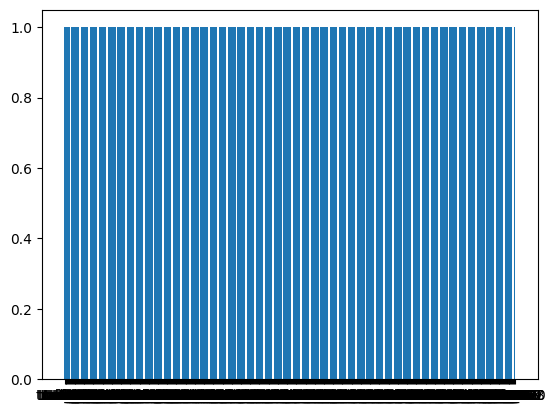

In [198]:
r2_df_full_sorted = r2_df_full.sort_values(by="r2_score", ascending=False)
plt.bar(r2_df_full_sorted["trait_index"], r2_df_full_sorted["r2_score"])

### Result Observation

The resulting $R^2$'s are too high due to small sample size. One way to resolve this is by increasing the sample size. Since we have trained the model_H, it should be able to generalize to other characters it has never enecountered. `

Follow-up analysis

In [199]:
import json
with open("..//data//moral_data_full.json", "r") as f:
    moral_data = json.load(f)

In [210]:
len(moral_data["moral_dialogue"])

1072

In [209]:
moral_data["moral_dialogue"]["Gandhi"]["GANDHI"]

[' (the eternal, earnest sophomore) No -- neither do I. But... (he points abruptly to the book) but this man is a Christian and he has written -- ',
 ' Why -- I -- I have a ticket. A First Class ticket. ',
 " I sent for it in the post. I'm an attorney, and I didn't have time to -- ",
 " (anger, a touch of panic) I always go First Class! I have traveled all over England and I've never... ",
 " But you're a rich man -- why do you put up with it? ",
 ' Well, then, it must be fought. We are children of God like everyone else. ',
 ' I -- I will write to the press -- here -- and in England. (He turns to Baker firmly) And I will use the courts. ',
 ' No. I asked my wife to organize that. ',
 ' Ladies and Gentlemen, we have asked you to gather here to help us proclaim our right to be treated as equal citizens of the Empire. ',
 ' We do not seek conflict. We know the strength of the forces arrayed against us, know that because of them we can only use peaceful means -- but we are determined that

In [206]:
moral_data["moral_dialogue"]["Robin Hood: Prince of Thieves"]["ROBIN"]

[" And this is English courage. He hurls his holders aside. Swings upward, driving his fast into the executioner's throat. Grabs the sword. Slash. His thongs melt like butter. A jailer leaps at him. Steaming, the scimitar slices into the man's chest. Despite his bindings, Peter wrestles the Interrogator. Knife pressed to his throat, Peter is forced against the furnace. At the last second, he flips the man into the fire. Screaming. ",
 ' Hmm!   Not bad. He runs the man through. Peter loses his sword. His opponent moves in for the kill... Peter grabs tongs from the fire and smolders his opponent with a backhand. Commotion outside.    RAISED VOICES and RUNNING FEET. ',
 ' Why should we trust you? ',
 ' A good point. He slashes the man free. ',
 ' Whatever blood is in his veins, he does not deserve to die here. ',
 " Five years I've waited for the smell of free air. That makes a man fast. Guards drop down from above, carrying torches.    Blocking the way. ",
 ' Amen, brother. A bloodcurdli